In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 함수

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

# 채권 혼합

In [3]:
# 코스피 ETF 채권 ETF 1:1 혼합

# 데이터 로드
kodex200 = getCloseData("069500", "2002") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

In [4]:
closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet

,Close,Close
Date,,
2002-10-14,5412,NaN
2002-10-15,5545,NaN
2002-10-16,5569,NaN
2002-10-17,5646,NaN
2002-10-18,5886,NaN
...,...,...
2022-06-09,34565,62800.0
2022-06-10,34210,62740.0
2022-06-13,33000,62055.0


In [5]:
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet

,kodex200,kodex10Bond
Date,,
2002-10-14,5412,NaN
2002-10-15,5545,NaN
2002-10-16,5569,NaN
2002-10-17,5646,NaN
2002-10-18,5886,NaN
...,...,...
2022-06-09,34565,62800.0
2022-06-10,34210,62740.0
2022-06-13,33000,62055.0


In [6]:
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21792,49960.0
2012-01-25,21868,49960.0
2012-01-26,21889,49930.0
2012-01-27,21923,50000.0
2012-01-30,21675,50130.0
...,...,...
2022-06-09,34565,62800.0
2022-06-10,34210,62740.0
2022-06-13,33000,62055.0


In [7]:
# 결측치 검사
pd.isnull(closeDataSet).sum()

kodex200       0
kodex10Bond    0
dtype: int64

**주식과 채권의 움직임 비교**

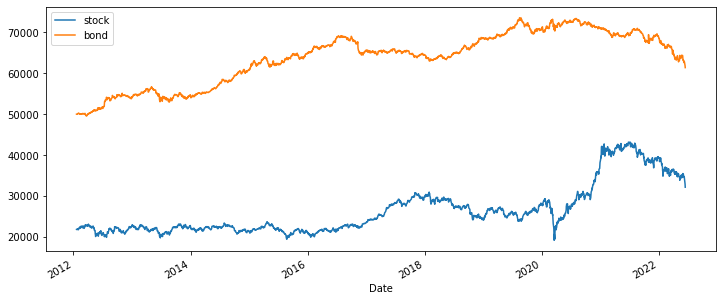

In [8]:
plt.figure(figsize=(12, 5))
closeDataSet['kodex200'].plot(label="stock")
closeDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

https://puzzle-puzzle.tistory.com/entry/%EC%A0%95%EA%B7%9C%EB%B6%84%ED%8F%AC

정규화 = $ \frac{주가 - 주가 평균}{주가 표준편차} $

In [9]:
# 데이터 정규화
normalizedCloseDataSet = (closeDataSet - closeDataSet.mean()) / closeDataSet.std()
normalizedCloseDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,-0.753198,-2.155082
2012-01-25,-0.740717,-2.155082
2012-01-26,-0.737268,-2.159768
2012-01-27,-0.731684,-2.148835
2012-01-30,-0.772413,-2.128530
...,...,...
2022-06-09,1.344525,-0.149610
2022-06-10,1.286223,-0.158981
2022-06-13,1.087503,-0.265971


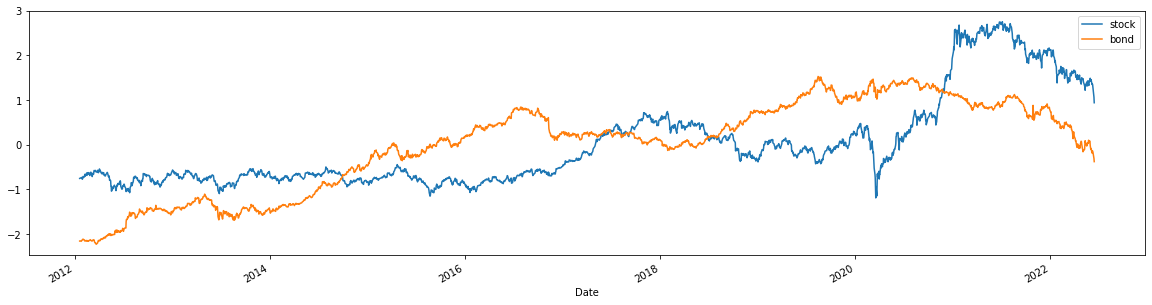

In [10]:
# 정규화 가격 시각화
plt.figure(figsize=(20, 5))
normalizedCloseDataSet['kodex200'].plot(label="stock")
normalizedCloseDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

최근 2022년부터는 금리인상으로 인해 채권과 주식 가격이 커플링되는 현상이 나타났지만, 일반적으로 채권과 주식은 반대로 움직이는 것을 확인했습니다.

### 주식 ETF 성과

우선 KODEX200은 코스피 200에 랭크된 종목에 골고루 분산투자하는 ETF입니다.  
이로 인해 분산투자를 했다고 가정하고,
주식 분산 투자 성과를 계산해보겠습니다.

In [11]:
kodex200DayReturn = getDayReturn(closeDataSet['kodex200'])
kodex200CumReturn = getCumulativeReturn(closeDataSet['kodex200'])

kodex200Cagr, kodex200Dd, kodex200Mdd = getEvaluation(kodex200CumReturn)

cagr: 1.0388936718564283
mdd: 38.08322008671455


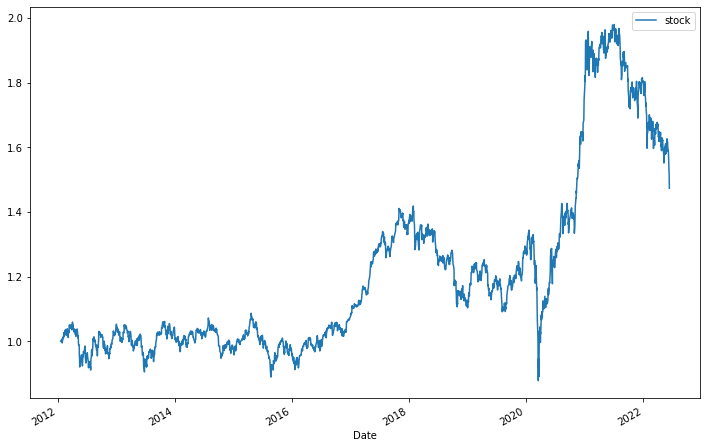

In [12]:
plt.figure(figsize=(12, 8))
kodex200CumReturn.plot(label="stock")
plt.legend()
plt.show()

## 채권 ETF와 1:1 혼합할 때 성과

In [13]:
# 지난번 구현해둔 함수를 사용해서 간편하게 구할 수 있음
portDayReturn, portCumReturn = getPortfolioResult(closeDataSet)

In [14]:
portCumReturn

Date
2012-01-20    1.000000
2012-01-25    1.001744
2012-01-26    1.001925
2012-01-27    1.003406
2012-01-30    0.999017
                ...   
2022-06-09    1.421569
2022-06-10    1.412823
2022-06-13    1.378205
2022-06-14    1.372671
2022-06-15    1.350515
Length: 2559, dtype: float64

In [15]:
# 투자 성과 cagr, dd, mdd
portCagr, portDd, portMdd = getEvaluation(portCumReturn)

cagr: 1.0300327765869794
mdd: 20.19116448178513


**시각화**

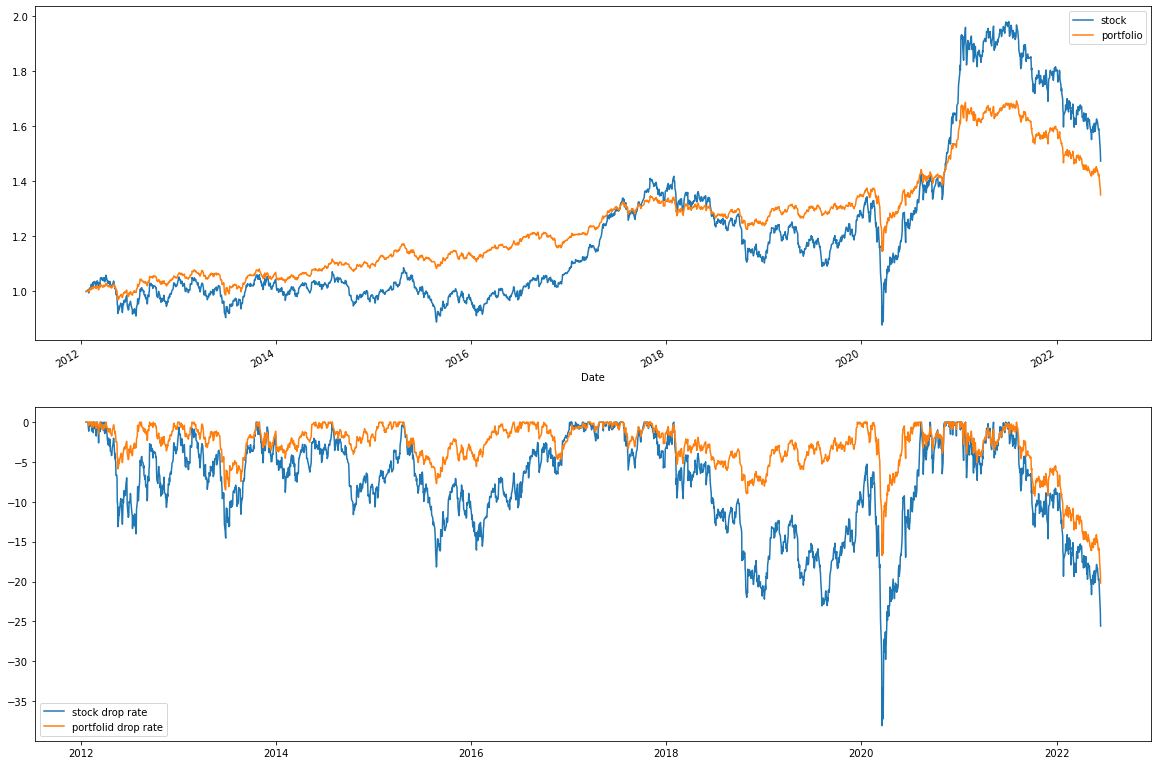

In [16]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd * -1, label="portfolid drop rate")
plt.legend()

plt.show()